#### Небольшой пример решения соревнования

### Импортим либы

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.__version__

'1.10.2+cu113'

In [2]:
import numpy as np
import random
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
!nvidia-smi

Mon Feb 21 13:52:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   54C    P5    10W / 120W |   1245MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Смотрим на данные 



In [4]:
train_dataset = torchvision.datasets.ImageFolder('train/' + 'train') # загрузили данные трейн

Нарисуем несколько рандомных картинок из тренировочной выборки. 

In [5]:
class_names = train_dataset.classes # забираем метки классов

In [6]:
len(class_names)

200

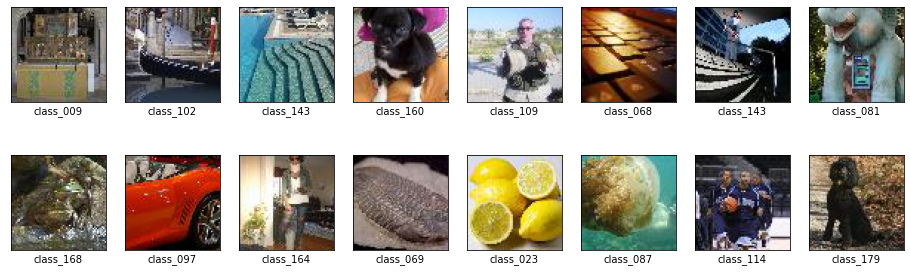

In [7]:
# отрисуем все что у нас есть
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(train_dataset))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_dataset[random_index][0])
        ax.set_xlabel(class_names[train_dataset[random_index][1]])
plt.show()

## 2.  Выбираем для нашей нейросети архитектуру

Свёрточная нейронная сеть строится из нескольких разных типов слоёв: 

* [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) - Конволюция
* [MaxPooling2D](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveMaxPool2d.html?highlight=maxpool#torch.nn.AdaptiveMaxPool2d) - макспулинг
* [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten) - разворачивает картинку в вектор 
* [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear) - полносвязный слой (fully-connected layer)
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU) - функция активации
* [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html?highlight=leaky#torch.nn.LeakyReLU) - leaky relu активация
* [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=nn%20dropout#torch.nn.Dropout) - дропаут.




In [8]:
# Смотрим что у нас там по девайсам
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [9]:
DEVICE

'cuda:0'

## 2.1 Полносвязная сетка 

Соберём полносвязную сетку с нашей предыдущей пары

**Важный момент:** после последнего FC слоя `softmax` не вызывается, т.к. он заложен внутрь [`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [10]:
RANDOM_SEED = 1234
torch.manual_seed(RANDOM_SEED)

In [11]:
batch_size = 2048 # Выбриаем размер батча
transform = torchvision.transforms.Compose([ # что нам делать по шагам в даталоудере
    torchvision.transforms.ToTensor(), # Пока просто переводим в тензор
    # Возможно стоит сделать что-то еще?
])

train_dataset = torchvision.datasets.ImageFolder('train/' + 'train',transform) # загрузили данные трейн



trainloader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(train_dataset, # Возможно не оптимально :)
                                          batch_size=batch_size,
                                       shuffle=False)


In [12]:
from tqdm import tqdm # Сколько там у нас что считается
import time
class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels = 3,
                                                  out_channels=18,
                                                  kernel_size=(5,5)),
                                        nn.ReLU(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=18,
                                                 out_channels=16,
                                                 kernel_size=(5,5)),
                                        nn.ReLU(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=16,
                                                 out_channels=120,
                                                 kernel_size=(4,4)),
                                        nn.Flatten(),# 120*10*10 размер. Как это можно посмотреть?
                                        nn.Linear(120*10*10, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 200),

                                        
                                    )
             
    def forward(self, x):
#         x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs



from copy import deepcopy
class Main_train_loop():
    def __init__(self,batch_size,trainloader,testloader,Device,model): 
        self.batch_size = batch_size
        self.trainloader = trainloader
        self.testloader = testloader
        self.device = Device
        self.model = model
        self.loss_arr = []
        self.loss_arr_test = []
        self.metric_train = []
        self.metric_test = []
        # self.get_part_train_loop()
    def get_part_train_loop(self): #,type_of_optimizer): - добавить выборк
        self.loss_fn = nn.CrossEntropyLoss()
        self.opt = optim.Adam(self.model.parameters(), lr=0.01)

    def accurancy(self,y_predicts,data_y):
        self.y_predicts = y_predicts
        self.data_y = data_y
        acc = (y_predicts == data_y).sum().item() / y_predicts.size(0)
        return acc

    def train_nn(self,trainloader, model, opt, loss_fn, device):
        running_loss = []
        model.train()
        acc_list = []
        for i, data in tqdm(enumerate(trainloader, 0)):
            inputs, labels = data # Взятие данных
            inputs = inputs.to(device) # положили данные на GPU
            labels = labels.to(device) # положили данные на GPU

            opt.zero_grad() # очистили градиент
            outputs,probs = model(inputs)# Считаем прогноз
            y_pred = outputs.argmax(dim=1) # Посчитали прогнозы
            loss = loss_fn(outputs, labels) # посчитали лосс
            loss.backward() # посчитали градиенты
            opt.step() # сделали шаг градиентного спуска

            running_loss.append(loss.item()) # разное всякое (метрики, лоссы)
            acc_list.append(self.accurancy(y_pred,
                                           labels))

        return model, running_loss,acc_list


    def eval_nn(self,testloader, model, loss_fn, device):
        running_loss_test = []
        acc_list = []

        model.eval()
        predicts = np.array([])
        
        for i, data in enumerate(testloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)

            outputs,proba = model(inputs)
            y_pred = outputs.cpu().argmax(dim=1)
            predicts = np.append(predicts,y_pred)
            loss = loss_fn(outputs.cpu(), labels)

            running_loss_test.append(loss.item())
            acc_list.append(self.accurancy(y_pred,
                                           labels))
        return running_loss_test, predicts.astype(int),acc_list

    def training_loop(self, max_epochs=20):
      
        for epoch in range(max_epochs):
            start_time = time.time()
            self.model, running_loss,acc_train = self.train_nn(self.trainloader, 
                                                             self.model,
                                         self.opt, self.loss_fn, self.device)
            running_loss_test, _,acc_eval = self.eval_nn(self.testloader,
                                         self.model,
                                         self.loss_fn, self.device)

            self.loss_arr.append(np.mean(running_loss))
            self.loss_arr_test.append(np.mean(running_loss_test))


            self.metric_train.append(np.mean(acc_train))
            self.metric_test.append(np.mean(acc_eval))
            if np.mean(acc_eval)>=np.max(self.metric_test):
                self.best_model = deepcopy(self.model)
                self.best_epoch = epoch

            
            duration = time.time() - start_time
            print(f"""EPOCH {epoch} : train_loss: {self.metric_train[-1]:.5f} 
            test_loss: {self.metric_test[-1]:.5f}.
            Заняло времени {round(duration,2)} секунд""")




        



In [13]:
model = CNN() # инициализировали модель
model.to(DEVICE) # положили на gpu
main_loop = Main_train_loop(batch_size,trainloader,valloader,DEVICE,model) # инициализировали обучающий класс
main_loop.get_part_train_loop()# добавили оптимизатор в самом классе

In [14]:
main_loop.training_loop(50)

49it [00:53,  1.09s/it]


EPOCH 0 : train_loss: 0.00433 
            test_loss: 0.00498.
            Заняло времени 98.3 секунд


49it [00:52,  1.08s/it]


EPOCH 1 : train_loss: 0.00448 
            test_loss: 0.00498.
            Заняло времени 98.13 секунд


49it [00:52,  1.08s/it]


EPOCH 2 : train_loss: 0.00438 
            test_loss: 0.00498.
            Заняло времени 98.2 секунд


49it [00:52,  1.08s/it]


EPOCH 3 : train_loss: 0.00452 
            test_loss: 0.00498.
            Заняло времени 98.36 секунд


49it [00:52,  1.08s/it]


EPOCH 4 : train_loss: 0.00425 
            test_loss: 0.00498.
            Заняло времени 98.25 секунд


49it [00:52,  1.08s/it]


EPOCH 5 : train_loss: 0.00432 
            test_loss: 0.00498.
            Заняло времени 98.31 секунд


49it [00:52,  1.08s/it]


EPOCH 6 : train_loss: 0.00416 
            test_loss: 0.00498.
            Заняло времени 98.67 секунд


49it [00:52,  1.07s/it]


EPOCH 7 : train_loss: 0.00429 
            test_loss: 0.00498.
            Заняло времени 98.32 секунд


49it [00:52,  1.07s/it]


EPOCH 8 : train_loss: 0.00445 
            test_loss: 0.00498.
            Заняло времени 96.57 секунд


49it [00:51,  1.05s/it]


EPOCH 9 : train_loss: 0.00440 
            test_loss: 0.00498.
            Заняло времени 95.62 секунд


49it [00:51,  1.05s/it]


EPOCH 10 : train_loss: 0.00399 
            test_loss: 0.00602.
            Заняло времени 95.32 секунд


49it [00:51,  1.05s/it]


EPOCH 11 : train_loss: 0.00455 
            test_loss: 0.00498.
            Заняло времени 95.43 секунд


49it [00:51,  1.05s/it]


EPOCH 12 : train_loss: 0.00474 
            test_loss: 0.00498.
            Заняло времени 96.24 секунд


49it [00:52,  1.07s/it]


EPOCH 13 : train_loss: 0.00461 
            test_loss: 0.00498.
            Заняло времени 98.62 секунд


49it [00:52,  1.08s/it]


EPOCH 14 : train_loss: 0.00461 
            test_loss: 0.00498.
            Заняло времени 98.63 секунд


49it [00:53,  1.09s/it]


EPOCH 15 : train_loss: 0.00452 
            test_loss: 0.00498.
            Заняло времени 100.23 секунд


49it [00:53,  1.10s/it]


EPOCH 16 : train_loss: 0.00412 
            test_loss: 0.00498.
            Заняло времени 100.57 секунд


49it [00:53,  1.10s/it]


EPOCH 17 : train_loss: 0.00454 
            test_loss: 0.00498.
            Заняло времени 100.86 секунд


49it [00:54,  1.11s/it]


EPOCH 18 : train_loss: 0.00452 
            test_loss: 0.00498.
            Заняло времени 101.44 секунд


49it [00:54,  1.10s/it]


EPOCH 19 : train_loss: 0.00432 
            test_loss: 0.00498.
            Заняло времени 101.35 секунд


49it [00:54,  1.11s/it]


EPOCH 20 : train_loss: 0.00439 
            test_loss: 0.00498.
            Заняло времени 102.23 секунд


49it [00:54,  1.11s/it]


EPOCH 21 : train_loss: 0.00452 
            test_loss: 0.00498.
            Заняло времени 101.99 секунд


49it [00:54,  1.11s/it]


EPOCH 22 : train_loss: 0.00464 
            test_loss: 0.00498.
            Заняло времени 102.07 секунд


49it [00:54,  1.11s/it]


EPOCH 23 : train_loss: 0.00470 
            test_loss: 0.00498.
            Заняло времени 101.98 секунд


49it [00:54,  1.11s/it]


EPOCH 24 : train_loss: 0.00442 
            test_loss: 0.00498.
            Заняло времени 102.19 секунд


49it [00:54,  1.11s/it]


EPOCH 25 : train_loss: 0.00463 
            test_loss: 0.00498.
            Заняло времени 102.04 секунд


49it [00:54,  1.12s/it]


EPOCH 26 : train_loss: 0.00441 
            test_loss: 0.00498.
            Заняло времени 102.75 секунд


49it [00:54,  1.12s/it]


EPOCH 27 : train_loss: 0.00435 
            test_loss: 0.00498.
            Заняло времени 103.09 секунд


49it [00:55,  1.12s/it]


EPOCH 28 : train_loss: 0.00451 
            test_loss: 0.00498.
            Заняло времени 103.58 секунд


49it [00:55,  1.14s/it]


EPOCH 29 : train_loss: 0.00417 
            test_loss: 0.00498.
            Заняло времени 104.24 секунд


49it [00:55,  1.13s/it]


EPOCH 30 : train_loss: 0.00438 
            test_loss: 0.00498.
            Заняло времени 103.71 секунд


49it [00:55,  1.13s/it]


EPOCH 31 : train_loss: 0.00436 
            test_loss: 0.00498.
            Заняло времени 103.61 секунд


49it [00:55,  1.13s/it]


EPOCH 32 : train_loss: 0.00445 
            test_loss: 0.00498.
            Заняло времени 103.2 секунд


49it [00:55,  1.13s/it]


EPOCH 33 : train_loss: 0.00421 
            test_loss: 0.00498.
            Заняло времени 103.29 секунд


49it [00:55,  1.13s/it]


EPOCH 34 : train_loss: 0.00442 
            test_loss: 0.00498.
            Заняло времени 103.73 секунд


49it [00:55,  1.13s/it]


EPOCH 35 : train_loss: 0.00424 
            test_loss: 0.00498.
            Заняло времени 103.38 секунд


49it [00:55,  1.13s/it]


EPOCH 36 : train_loss: 0.00451 
            test_loss: 0.00498.
            Заняло времени 103.63 секунд


49it [00:55,  1.13s/it]


EPOCH 37 : train_loss: 0.00459 
            test_loss: 0.00498.
            Заняло времени 103.72 секунд


49it [00:55,  1.13s/it]


EPOCH 38 : train_loss: 0.00438 
            test_loss: 0.00498.
            Заняло времени 103.54 секунд


49it [00:55,  1.13s/it]


EPOCH 39 : train_loss: 0.00460 
            test_loss: 0.00498.
            Заняло времени 104.04 секунд


49it [00:55,  1.14s/it]


EPOCH 40 : train_loss: 0.00461 
            test_loss: 0.00498.
            Заняло времени 104.42 секунд


49it [00:55,  1.14s/it]


EPOCH 41 : train_loss: 0.00449 
            test_loss: 0.00498.
            Заняло времени 104.45 секунд


49it [00:55,  1.14s/it]


EPOCH 42 : train_loss: 0.00452 
            test_loss: 0.00498.
            Заняло времени 104.3 секунд


49it [00:55,  1.13s/it]


EPOCH 43 : train_loss: 0.00452 
            test_loss: 0.00498.
            Заняло времени 103.95 секунд


49it [00:55,  1.13s/it]


EPOCH 44 : train_loss: 0.00420 
            test_loss: 0.00498.
            Заняло времени 103.83 секунд


49it [00:55,  1.13s/it]


EPOCH 45 : train_loss: 0.00431 
            test_loss: 0.00498.
            Заняло времени 103.73 секунд


49it [00:55,  1.13s/it]


EPOCH 46 : train_loss: 0.00427 
            test_loss: 0.00498.
            Заняло времени 103.71 секунд


49it [00:55,  1.13s/it]


EPOCH 47 : train_loss: 0.00454 
            test_loss: 0.00498.
            Заняло времени 103.76 секунд


49it [00:55,  1.13s/it]


EPOCH 48 : train_loss: 0.00431 
            test_loss: 0.00498.
            Заняло времени 103.68 секунд


49it [00:55,  1.13s/it]


EPOCH 49 : train_loss: 0.00438 
            test_loss: 0.00498.
            Заняло времени 103.71 секунд


In [20]:
torch.save(main_loop.best_model, 'first_model.pt')

In [1]:
### Инференсе модели на тесте

In [14]:

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self): 
        super().__init__()
        self.classifier = nn.Sequential(nn.Conv2d(in_channels = 3,
                                                  out_channels=18,
                                                  kernel_size=(5,5)),
                                        nn.ReLU(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=18,
                                                 out_channels=16,
                                                 kernel_size=(5,5)),
                                        nn.ReLU(),
                                        nn.AvgPool2d(kernel_size=(2,2),
                                                    stride=(2,2)),
                                        nn.Conv2d(in_channels=16,
                                                 out_channels=120,
                                                 kernel_size=(4,4)),
                                        nn.Flatten(),# 120*10*10 размер. Как это можно посмотреть?
                                        nn.Linear(120*10*10, 84),
                                        nn.ReLU(),
                                        nn.Linear(84, 200),

                                        
                                    )
             
    def forward(self, x):
#         x = x.reshape(x.size(0), -1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1) # if no dim is given, then a warning will appear
        return logits,probs

## Нужно взять класс модели. Мы храним конкретную реализацию
best_model = torch.load('first_model.pt')
best_model = best_model.cuda()
best_model.eval()

CNN(
  (classifier): Sequential(
    (0): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (3): Conv2d(18, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=12000, out_features=84, bias=True)
    (9): ReLU()
    (10): Linear(in_features=84, out_features=200, bias=True)
  )
)

In [18]:
import PIL.Image
import PIL
import os
from tqdm import tqdm

def predict(path,best_model):
    image = PIL.Image.open(f'val_kaggle/val_kaggle/{path}') # загрузили
    image = torchvision.transforms.ToTensor()(image) # ковертнули в тензор
    if image.shape[0]==1: # часть картинок в тесте черно белые
        image = torch.concat([image]*3) # добавим 3 канала (чтобы сделать чернобелое ргб. Такой быстрый костыль)
        
        


    image = image[None] # добавили фейковую размерность
    image = image.cuda() # переведем на гпу (либо модель на cpu)

    # Predict class scores
    logits,prediction = best_model(image) # прогнозируем
    class_label = torch.argmax(prediction).item()
    return class_label

In [19]:
images_path = os.listdir('val_kaggle/val_kaggle') # список картинок для теста

In [20]:
id_list = []
predict_list = []
for path in tqdm(images_path):
    id_list.append(path.replace('.jpg',''))
    predict_list.append(predict(path,best_model))

    

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 800.82it/s]


In [24]:
import pandas as pd
df_predictions = pd.read_csv('Example_result.csv') # Загрузили пример сабмита

In [26]:
df_predictions['ID'] = id_list
df_predictions['Lable'] = predict_list
df_predictions.to_csv('our_first_predict.csv',index=False)